In [3]:
using ConstrainedLasso, PyPlot

In [2]:
# a function pava for pooled adjacent violation algorithm

function pava(v; w = ones(length(v)))
    n = length(v);
    if n != length(w)
        throw(DimensionMismatch("Lengths of values and weights mismatch"))
    end
    
    out = ones(n);
    j = 1;
    S = Dict(0 => 0, 1 => 1);
    vdash = Dict(1 => v[1]);
    wdash = Dict(1 => w[1]);
    @inbounds begin
        for i = 2:n
            j = j+1;
            vdash[j] = v[i];
            wdash[j] = w[i];
            while j > 1 && vdash[j] < vdash[j-1];
                vdash[j-1] = (wdash[j] * vdash[j] + wdash[j-1] * vdash[j-1]) /
                   (wdash[j] + wdash[j-1]);
                wdash[j-1] = wdash[j] + wdash[j-1];
                j = j-1;
            end
            S[j] = i;
        end
        for k = 1:j
            for l in S[k-1]+1 : S[k]
                out[l] = vdash[k];
            end
        end
    end
    return out
end

# a function quadratic to solve a univariate quadratic equation

function quadratic(a, b, c)
    discr = b^2 - 4*a*c
    return (-b + sqrt(discr))/(2a)
end

quadratic (generic function with 1 method)

In [57]:
# a function for BSGM_iso (Section 2,3)

# y                  : a noisy observation of an isotonic sequence
# init_theta         : initialization of theta, with default a pava solution
# lambda0, lambda1   : tuning parameters
# convtol            : convergence tolerance
# iter               : a number of maximum allowed iteration

function BGSM_iso(y; init_y = pava(y), lambda0 = 1e-1, lambda1 = 1e4, iter = 1000)
    n = length(y);
    
    # initialize
    q = 0.5 * ones(n-1);
    alpha = mean(y);
    theta = init_y - alpha;
    sigma = sqrt(sum((y - alpha - theta).^2)/n);
    delta = theta[2:end] - theta[1:end-1];
    eta = 1/2;
    
    # loop start
    for i = 1:1000
        
        # E-step: update q and tau
        q_old = copy(q);
        q = 1./( 1 + (1-eta)/eta * lambda0/lambda1 * exp.(delta/sigma*(1/lambda0-1/lambda1)) );
        tau = q/lambda0 + (1-q)/lambda1;
        
        # M-step: update sigma, theta, delta, eta
        a = n + sum(q) + 2; b = -sum(delta .* q); c = -sum((y - alpha - theta).^2);
        sigma = quadratic(a,b,c)
        theta = pava(y - alpha - [0;tau] * sigma + [tau;0] * sigma);
        delta = theta[2:end] - theta[1:end-1];
        eta   = sum(q)/(n-1);
        
        # check convergence
        if norm(q_old - q) < 1e-10
            break;
        end
        
    end
    
    # return
    return Dict([
                (:alpha,alpha), (:theta,theta), (:sigma, sigma), (:q,q), (:eta,eta),
                (:delta,delta), (:alpha_theta, alpha + theta)
                ])
end

# a function for model selection

function model_selection(out; lambda1 = 1e4)
    t = out[:alpha_theta]; sigma = out[:sigma]; d = out[:delta];
    first_term = sum((y-t).^2)/(2 * sigma^2);
    second_term = sum(d)/(sigma * lambda1);
    third_term = sum(d .> 1e-4) * log(sigma * lambda1);
    return first_term + second_term + third_term
end

model_selection (generic function with 1 method)

In [58]:
out1 = BGSM_iso(y; lambda0 = 10^(-0.12), lambda1 = lambda1);

In [4]:
warming = readcsv(joinpath(Pkg.dir("ConstrainedLasso"),"docs/src/demo/misc/warming.csv"), header=true)[1];
year = warming[:, 1];
y    = warming[:, 2];
hcat(year, y);
length(y)

166

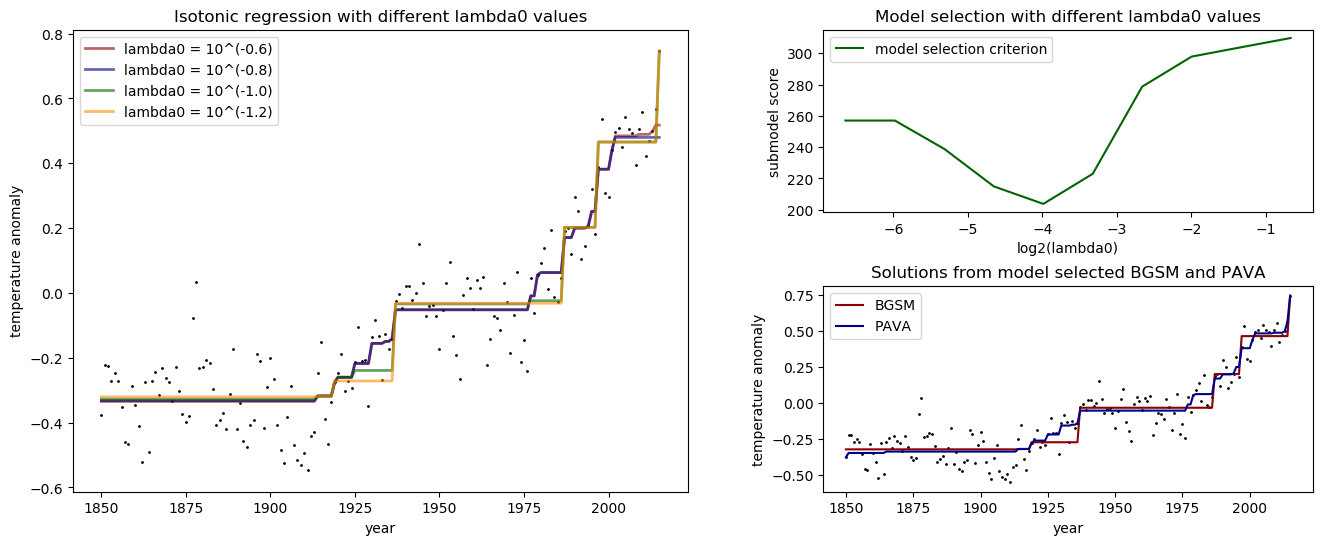

In [59]:
lambda1 = 1e4
out1 = BGSM_iso(y; lambda0 = 10^(-0.6), lambda1 = lambda1);
out2 = BGSM_iso(y; lambda0 = 10^(-0.8), lambda1 = lambda1);
out3 = BGSM_iso(y; lambda0 = 10^(-1.0), lambda1 = lambda1);
out4 = BGSM_iso(y; lambda0 = 10^(-1.2), lambda1 = lambda1);

################################################################################
lambda0_range = 10.^(-(0.2:0.2:2));
out = zeros(length(lambda0_range));
for i = 1:length(lambda0_range)
    out[i] = model_selection(BSGM_iso(y, lambda0 = lambda0_range[i], lambda1 = lambda1))
end
min_ind = findmin(out)[2];
final = BSGM_iso(y; lambda0 = lambda0_range[min_ind], lambda1 = lambda1)

################################################################################
fig, axs = subplots(2, 3, figsize = (16, 6))
ax = subplot2grid((20,20), (0,0), rowspan = 20, colspan = 10)
ax[:plot](year, out1[:alpha_theta], "r-", linewidth=2, color = "darkred", label="lambda0 = 10^(-0.6)", alpha=0.6)
ax[:plot](year, out2[:alpha_theta], "r-", linewidth=2, color = "darkblue", label="lambda0 = 10^(-0.8)", alpha=0.6)
ax[:plot](year, out3[:alpha_theta], "r-", linewidth=2, color = "darkgreen", label="lambda0 = 10^(-1.0)", alpha=0.6)
ax[:plot](year, out4[:alpha_theta], "r-", linewidth=2, color = "darkorange", label="lambda0 = 10^(-1.2)", alpha=0.6)
ax[:scatter](year, y, s = 1, color = "black")
ax[:legend](loc="upper left")
xlabel("year"); ylabel("temperature anomaly")
title("Isotonic regression with different lambda0 values")

################################################################################
ax2 = subplot2grid((20,20), (0,12), rowspan = 8, colspan = 8)
ax2[:plot](log2.(lambda0_range),out, color = "darkgreen", label = "model selection criterion");
ax2[:legend](loc="upper left")
xlabel("log2(lambda0)")
ylabel("submodel score")
title("Model selection with different lambda0 values")
ax3 = subplot2grid((20,20), (11,12), rowspan = 10, colspan = 8)
ax3[:plot](year,final[:alpha_theta], color = "darkred", label="BGSM")
ax3[:plot](year,pava(y), color = "darkblue", label="PAVA")
ax3[:scatter](year,y, s = 1, color = "black")
ax3[:legend](loc="upper left")
xlabel("year");
ylabel("temperature anomaly")
title("Solutions from model selected BGSM and PAVA")
savefig("figure/F1.pdf")

In [9]:
# using RCall
# R"require(neariso)";
# @rput y;
# R"out_neariso <- neariso(y, lambda = 0.5)$beta";
# out_neariso = (@rget out_neariso)[:];
# plot(year, out_neariso, linewidth = 1)